### Import Data

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [69]:
# import data
dir_data = 'C:\\Users\\user\\Desktop\\MultiChart\\寒假作業\\TMBA-20200108\\IF'
Data_Path = os.path.join(dir_data, 'IF-60-None-0.txt')
IF = pd.read_csv(Data_Path, engine='python')
IF.dropna(how='any',inplace=True)
IF.columns = ['Date_Time','Open','High','Low','Close','TotalVolume', 'Drop']
IF = IF.drop(columns = ['Drop'])
IF['Date'] = IF['Date_Time'].str.split(pat = " ", expand=True).iloc[:, 0]
IF['Time'] = IF['Date_Time'].str.split(pat = " ", expand=True).iloc[:, 1]
IF.Date = pd.to_datetime(IF.Date)
IF.Time = pd.to_datetime(IF.Time)
IF.Date_Time = pd.to_datetime(IF.Date_Time)

# from min k to Day k 
period_type = '1D'
IF = IF.set_index('Date_Time')
IF = IF.resample(period_type,how='last')
IF['open_%s'%(period_type)] = IF['Open'].resample(period_type,how='first')
IF['close_%s'%(period_type)] = IF['Close'].resample(period_type,how='last')
IF['high_%s'%(period_type)] = IF['High'].resample(period_type,how='max')
IF['low_%s'%(period_type)] = IF['Low'].resample(period_type,how='min')
IF['volume_%s'%(period_type)] = IF['TotalVolume'].resample(period_type,how='sum')
IF.dropna(how='any',inplace=True)

# Sort IF by Date
IF = IF.sort_values(by = ['Date_Time'])
IF.head()

,Open,High,Low,Close,TotalVolume,Date,Time,open_1D,close_1D,high_1D,low_1D,volume_1D
Date_Time,,,,,,,,,,,,
2010-04-16,3428.2,3428.2,3425.2,3426.0,3242.0,2010-04-16,2020-02-23 14:59:00,3428.2,3426.0,3428.2,3425.2,3242.0
2010-04-27,3138.8,3138.8,3138.8,3138.8,7387.0,2010-04-27,2020-02-23 15:15:00,3138.8,3138.8,3138.8,3138.8,7387.0
2010-04-28,3129.0,3129.0,3129.0,3129.0,7095.0,2010-04-28,2020-02-23 15:15:00,3129.0,3129.0,3129.0,3129.0,7095.0
2010-04-29,3083.8,3083.8,3083.8,3083.8,8707.0,2010-04-29,2020-02-23 15:15:00,3083.8,3083.8,3083.8,3083.8,8707.0
2010-04-30,3107.0,3107.0,3107.0,3107.0,8299.0,2010-04-30,2020-02-23 15:15:00,3107.0,3107.0,3107.0,3107.0,8299.0


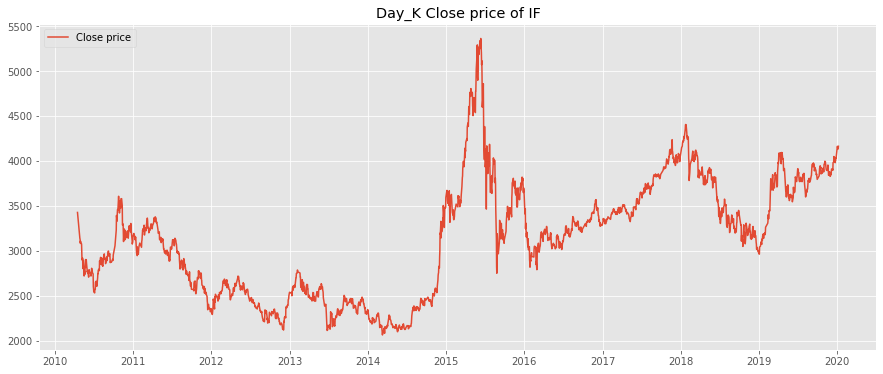

In [71]:
plt.figure(figsize=(15,6))
plt.title("Day_K Close price of IF")
plt.plot(IF['Date'], IF['close_1D'], label='Close price')
plt.legend(loc='upper left')
plt.show()

### Split Data

In [74]:
#Split data (Train/ Test)
start_date = datetime.strptime('2010-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2014-12-31', '%Y-%m-%d')
start_date1 = datetime.strptime('2016-01-01', '%Y-%m-%d')
end_date1 = datetime.strptime('2020-12-31', '%Y-%m-%d')
msk = (IF['Date'] <= end_date) & (IF['Date'] >= start_date)
msk2 = (IF['Date'] <= end_date1) & (IF['Date'] >= start_date1)
IF_train = IF.loc[msk]
IF_test = IF.loc[msk2]

### Build Strategy Signals

In [118]:
# Import Bollinger_bands
from pyti.bollinger_bands import upper_bollinger_band as ubb
from pyti.bollinger_bands import middle_bollinger_band as mbb
from pyti.bollinger_bands import lower_bollinger_band as lbb
from pyti.bollinger_bands import percent_bandwidth as percent_b

In [251]:
# Initialize the short and long windows
window = 14
no_std = 1.3
band_per = 0.2

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame()

# Bollinger Band
signals['Price'] = IF_train['Close']
signals['upper_band'] = ubb(IF_train['Close'], period = window, std_mult = no_std)
signals['mid_band'] = mbb(IF_train['Close'], period = window, std = no_std)
signals['lower_band'] = lbb(IF_train['Close'], period = window, std = no_std)
signals['percent_b'] = percent_b(IF_train['Close'], period = window, std = no_std)


# Create signals
signals['positions'] = 0.0
 
condition1 = np.where((signals['Price'][window:] > signals['upper_band'][window:]))
condition2 = np.where((signals['Price'][window:] < signals['lower_band'][window:]))

signals['positions'][condition1[0]] = 1
signals['positions'][condition2[0]] = -1

# Generate trading orders
signals['signal'] = signals['positions'].shift(1).diff()
signals['signal'] = signals['positions'].shift(1).diff()

# Set_index('Date_Time')
signals['Date'] = IF_train['Date']
signals = signals.set_index('Date')

# Print `signals
print(signals)

             Price   upper_band     mid_band   lower_band  percent_b  \
Date                                                                   
2010-04-16  3426.0          NaN          NaN          NaN        NaN   
2010-04-27  3138.8          NaN          NaN          NaN        NaN   
2010-04-28  3129.0          NaN          NaN          NaN        NaN   
2010-04-29  3083.8          NaN          NaN          NaN        NaN   
2010-04-30  3107.0          NaN          NaN          NaN        NaN   
...            ...          ...          ...          ...        ...   
2014-12-25  3381.0  3423.708605  3305.071429  3186.434252   0.820003   
2014-12-26  3483.0  3448.970529  3316.200000  3183.429471   1.128151   
2014-12-29  3474.6  3466.722122  3339.885714  3213.049307   1.031055   
2014-12-30  3482.6  3486.510445  3357.957143  3229.403840   0.984791   
2014-12-31  3593.2  3524.063126  3385.485714  3246.908303   1.249452   

            positions  signal  
Date                           

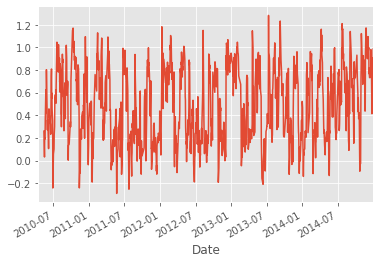

In [170]:
# Plot the band_width
signals['percent_b'].plot()

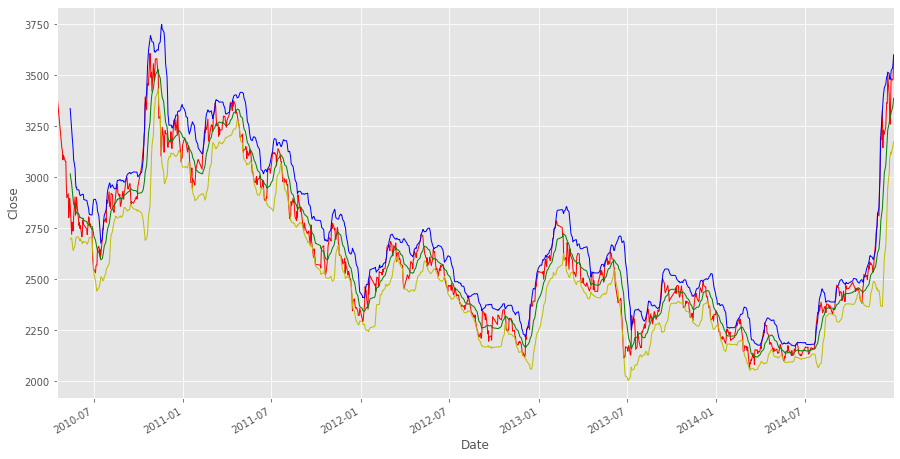

In [195]:
# Plot Bollinger Band
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(111,  xlabel = 'Date',ylabel='Close')

signals['Price'].plot(ax=ax1, color='r', lw=1)
signals['upper_band'].plot(ax=ax1, color = 'b', lw= 1)
signals['mid_band'].plot(ax=ax1, color = 'g', lw= 1)
signals['lower_band'].plot(ax=ax1, color = 'y', lw= 1)

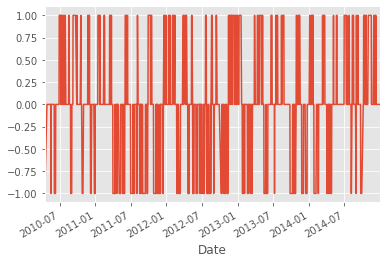

In [252]:
signals.positions.plot()

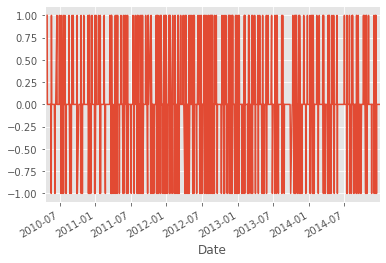

In [253]:
signals.signal.plot()

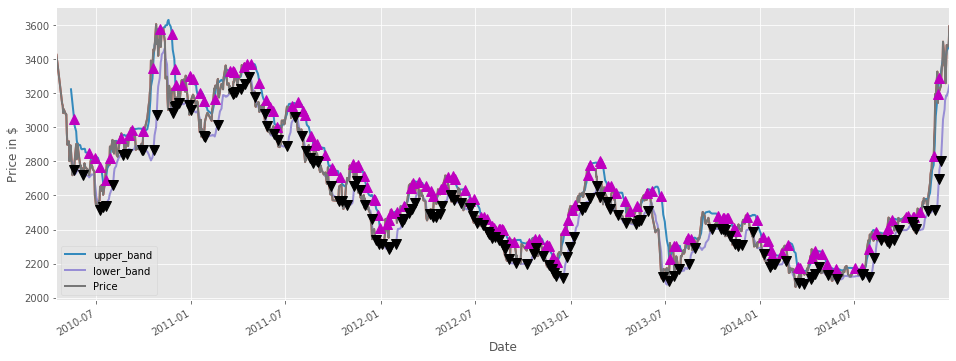

In [254]:
# Initialize the plot figure
fig = plt.figure(figsize=(16,6))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
ax1.plot(IF_train['Date'], IF_train['close_1D'],lw=2.)

# Plot the short and long moving averages
signals[['upper_band', 'lower_band', 'Price']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.signal == 1.0].index, 
         signals.upper_band[signals.signal == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.signal == -1.0].index, 
         signals.lower_band[signals.signal == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [255]:
# Calculate Return 
Return = pd.DataFrame()
Return['Open'] = IF_train['Open']
Return['Close'] = IF_train['Close']
Return['Return_pct'] = (Return['Close'] - Return['Open']) * 100
Return['Return_mny'] = Return['Close'].diff(1)
Return['positions'] = signals['positions']
Return['Return'] = Return['Return_mny'] * Return['positions']
Return['Total_Return'] = Return['Return'].cumsum()

# Set_index('Date_Time')
Return['Date'] = IF_train['Date']
Return = Return.set_index('Date')

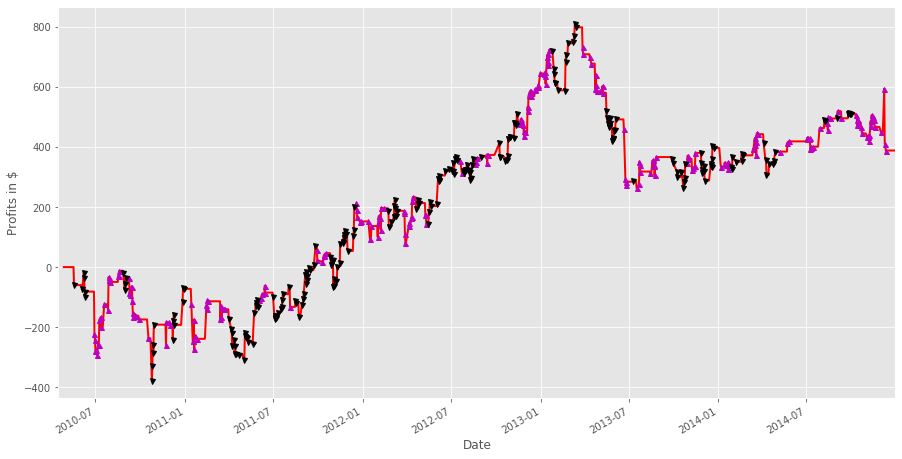

In [256]:
# Plotting the return 
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111, ylabel='Profits in $')

Return['Total_Return'].plot(ax=ax1, color='r', lw=2.)

# Placing markers for our position entry(long)
ax1.plot(Return.loc[Return.positions == 1.0].index,
    Return.Total_Return[Return.positions == 1.0],
    '^', markersize=5, color='m')

# Placing markers for our position exit(long)
ax1.plot(Return.loc[Return.positions == -1.0].index,
    Return.Total_Return[Return.positions == -1.0],
    'v', markersize=5, color='k')
plt.show()

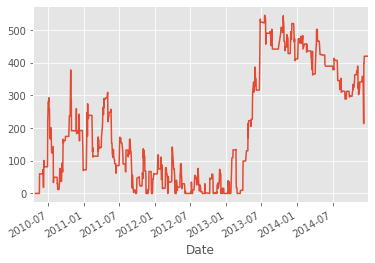

In [257]:
# MDD
MDD_series = Return['Total_Return'].cummax()-Return['Total_Return']
High_index = Return['Total_Return'][Return['Total_Return'].cummax() == Return['Total_Return']].index
MDD_series.plot()

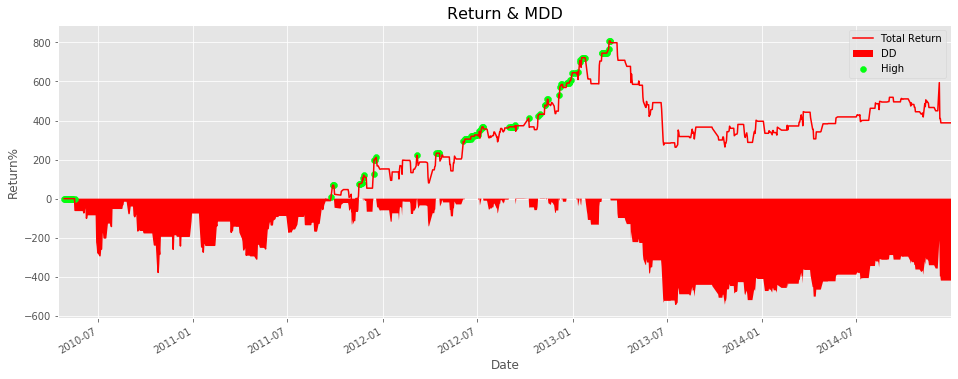

In [258]:
# Plot MDD
fig,ax=plt.subplots(figsize=(16,6))

Return['Total_Return'].plot(label='Total Return',ax=ax,c='r')
plt.fill_between(MDD_series.index,-MDD_series,0,facecolor='r',label='DD')
plt.scatter(High_index,Return['Total_Return'].loc[High_index],c='#02ff0f',label='High')

plt.legend()
plt.ylabel('Return%')
plt.xlabel('Date')
plt.title('Return & MDD',fontsize=16);

### Test data

In [259]:
# Initialize the short and long windows
window = 14
no_std = 1.3
band_per = 0.2

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame()

# Bollinger Band
signals['Price'] = IF_test['Close']
signals['upper_band'] = ubb(IF_test['Close'], period = window, std_mult = no_std)
signals['mid_band'] = mbb(IF_test['Close'], period = window, std = no_std)
signals['lower_band'] = lbb(IF_test['Close'], period = window, std = no_std)
signals['percent_b'] = percent_b(IF_test['Close'], period = window, std = no_std)


# Create signals
signals['positions'] = 0.0
 
condition1 = np.where((signals['Price'][window:] > signals['upper_band'][window:]))
condition2 = np.where((signals['Price'][window:] < signals['lower_band'][window:]))

signals['positions'][condition1[0]] = 1
signals['positions'][condition2[0]] = -1

# Generate trading orders
signals['signal'] = signals['positions'].shift(1).diff()
signals['signal'] = signals['positions'].shift(1).diff()

# Set_index('Date_Time')
signals['Date'] = IF_test['Date']
signals = signals.set_index('Date')

# Print `signals
print(signals)

             Price   upper_band     mid_band   lower_band  percent_b  \
Date                                                                   
2016-01-04  3425.0          NaN          NaN          NaN        NaN   
2016-01-05  3408.8          NaN          NaN          NaN        NaN   
2016-01-06  3465.0          NaN          NaN          NaN        NaN   
2016-01-07  3245.2          NaN          NaN          NaN        NaN   
2016-01-08  3309.0          NaN          NaN          NaN        NaN   
...            ...          ...          ...          ...        ...   
2019-12-31  4109.4  4083.594971  4018.342857  3953.090743   1.197733   
2020-01-02  4160.4  4102.569049  4037.271429  3971.973808   1.442826   
2020-01-03  4151.8  4121.613004  4049.571429  3977.529853   1.209511   
2020-01-06  4132.6  4133.277388  4059.900000  3986.522612   0.995384   
2020-01-07  4162.4  4148.825454  4068.057143  3987.288832   1.084034   

            positions  signal  
Date                           

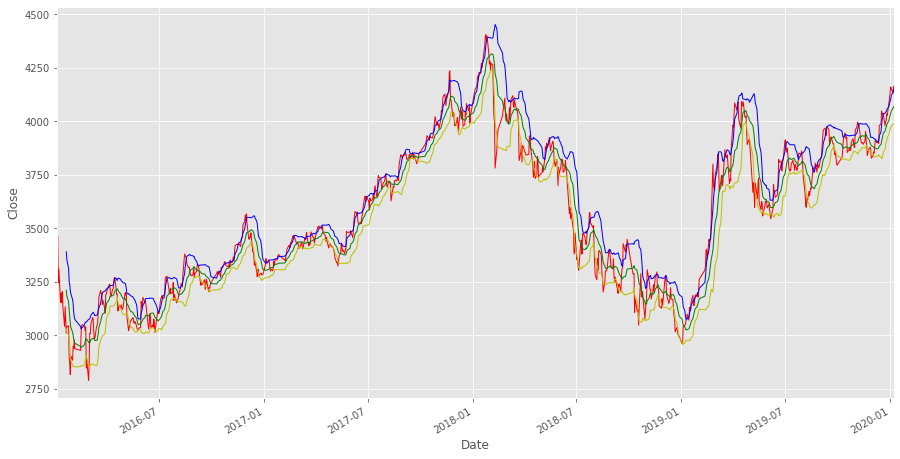

In [260]:
# Plot Bollinger Band
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(111,  xlabel = 'Date',ylabel='Close')

signals['Price'].plot(ax=ax1, color='r', lw=1)
signals['upper_band'].plot(ax=ax1, color = 'b', lw= 1)
signals['mid_band'].plot(ax=ax1, color = 'g', lw= 1)
signals['lower_band'].plot(ax=ax1, color = 'y', lw= 1)

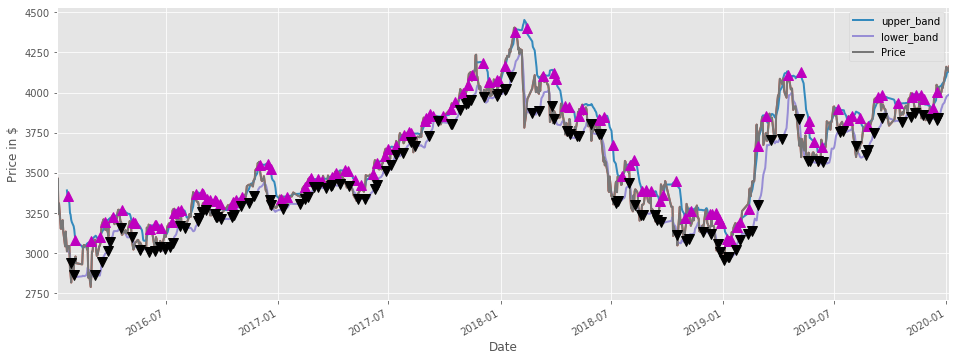

In [262]:
# Initialize the plot figure
fig = plt.figure(figsize=(16,6))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
ax1.plot(IF_test['Date'], IF_test['close_1D'],lw=2.)

# Plot the short and long moving averages
signals[['upper_band', 'lower_band', 'Price']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.signal == 1.0].index, 
         signals.upper_band[signals.signal == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.signal == -1.0].index, 
         signals.lower_band[signals.signal == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [263]:
# Calculate Return 
Return = pd.DataFrame()
Return['Open'] = IF_test['Open']
Return['Close'] = IF_test['Close']
Return['Return_pct'] = (Return['Close'] - Return['Open']) * 100
Return['Return_mny'] = Return['Close'].diff(1)
Return['positions'] = signals['positions']
Return['Return'] = Return['Return_mny'] * Return['positions']
Return['Total_Return'] = Return['Return'].cumsum()

# Set_index('Date_Time')
Return['Date'] = IF_test['Date']
Return = Return.set_index('Date')

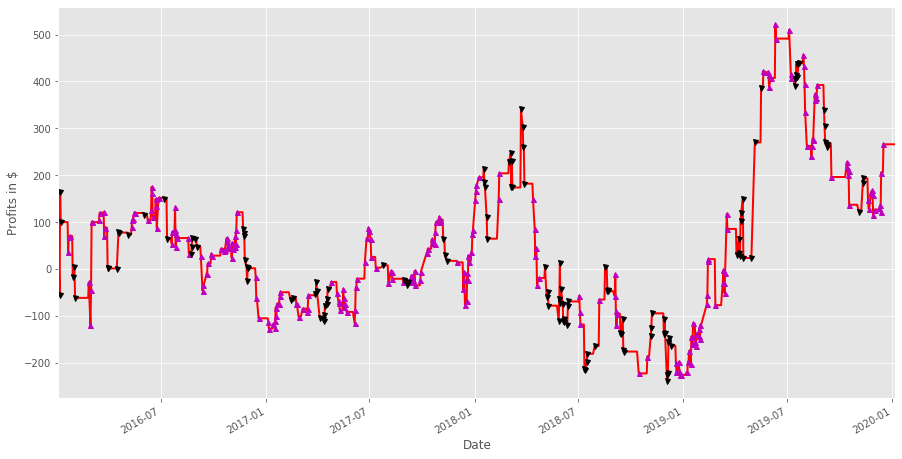

In [264]:
# Plotting the return 
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111, ylabel='Profits in $')

Return['Total_Return'].plot(ax=ax1, color='r', lw=2.)

# Placing markers for our position entry(long)
ax1.plot(Return.loc[Return.positions == 1.0].index,
    Return.Total_Return[Return.positions == 1.0],
    '^', markersize=5, color='m')

# Placing markers for our position exit(long)
ax1.plot(Return.loc[Return.positions == -1.0].index,
    Return.Total_Return[Return.positions == -1.0],
    'v', markersize=5, color='k')
plt.show()

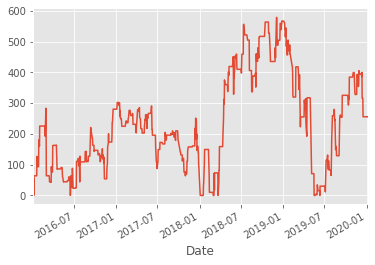

In [265]:
# MDD
MDD_series = Return['Total_Return'].cummax()-Return['Total_Return']
High_index = Return['Total_Return'][Return['Total_Return'].cummax() == Return['Total_Return']].index
MDD_series.plot()

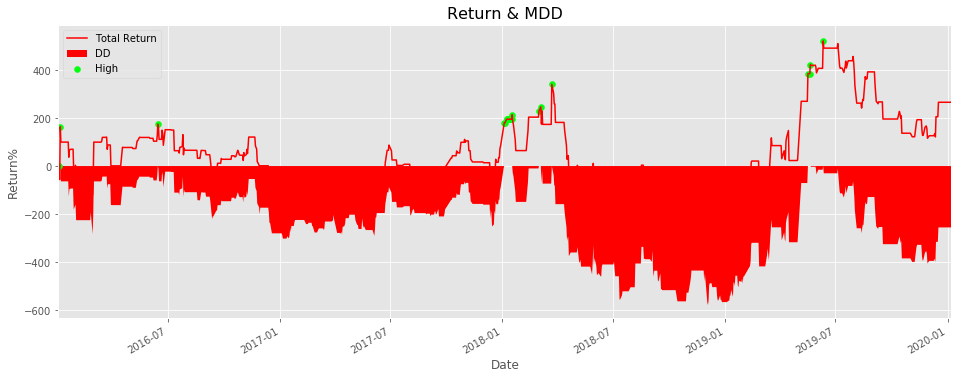

In [266]:
# Plot MDD
fig,ax=plt.subplots(figsize=(16,6))

Return['Total_Return'].plot(label='Total Return',ax=ax,c='r')
plt.fill_between(MDD_series.index,-MDD_series,0,facecolor='r',label='DD')
plt.scatter(High_index,Return['Total_Return'].loc[High_index],c='#02ff0f',label='High')

plt.legend()
plt.ylabel('Return%')
plt.xlabel('Date')
plt.title('Return & MDD',fontsize=16);